# Mask R-CNN Instance Segmentation

In this notebook, we will introduce [Mask R-CNN](https://arxiv.org/abs/1703.06870) for image segmentation.

## Image Segmentation

In the previous notebooks, we performed object detection, where bounding boxes are used to indicate the objects contained in an image.  For instance segmentation, we want the contours or masks of objects.

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497) and adds an extra branch for predicting segmentation masks for objects (instances).

## Initialization

In [1]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
import numpy as np
import random
import scrapbook as sb
import time


from pathlib import Path
from PIL import Image, ImageColor

# torch
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import unzip_url, get_files_in_directory
from utils_cv.common.gpu import which_processor
from utils_cv.common.plot import show_ims
from utils_cv.detection.bbox import _Bbox, AnnotationBbox
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import PennFudanDataset
from utils_cv.detection.mask import binarise_mask, merge_binary_masks
from utils_cv.detection.model import MaskLearner, KeypointLearner, get_pretrained_maskrcnn, get_pretrained_keypointrcnn
from utils_cv.detection.plot import plot_boxes, plot_keypoints, plot_mask
from utils_cv.detection.references.engine import train_one_epoch, evaluate
from utils_cv.detection.references.utils import collate_fn

# variables
palette = [
    ImageColor.getcolor('red', 'RGB'),
    ImageColor.getcolor('orange', 'RGB'),
    ImageColor.getcolor('yellow', 'RGB'),
    ImageColor.getcolor('green', 'RGB'),
    ImageColor.getcolor('blue', 'RGB'),
    ImageColor.getcolor('pink', 'RGB'),
    ImageColor.getcolor('white', 'RGB'),
    ImageColor.getcolor('purple', 'RGB'),
]
device = torch.device('cpu')

which_processor()

Torch is using GPU: Quadro P400


## Browse the Dataset

We are going to use the [Fenn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/) for illustration.  This dataset includes 170 images with 345 labeled pedestrians in total, where 96 images are taken from around University of Pennsylvania, and other 74 are taken from around Fudan University.

```
PennFudanPed/
├── Annotation
│   ├── FudanPed00001.txt
│   ├── ...
│   ├── FudanPed00074.txt
│   ├── PennPed00001.txt
│   ├── ...
│   └── PennPed00096.txt
├── PedMasks
│   ├── FudanPed00001_mask.png
│   ├── ...
│   ├── FudanPed00074_mask.png
│   ├── PennPed00001_mask.png
│   ├── ...
│   └── PennPed00096_mask.png
└── PNGImages
    ├── FudanPed00001.png
    ├── ...
    ├── FudanPed00074.png
    ├── PennPed00001.png
    ├── ...
    └── PennPed00096.png
```

In [3]:
# download PennFudan dataset
DATA_PATH = Path(unzip_url(Urls.penn_fudan_ped_path, exist_ok=True))

The `PNGImages` and `PedMasks` folder contain original images and their corresponding masks.  The annotations in the `Annotation` folder are of format [PASCAL VOC version 1.00](http://host.robots.ox.ac.uk/pascal/VOC/), which is a plain text file with key-value pairs separated by colon.

In [4]:
# list of the paths of images, masks and annotations,
# sorting them to ensure that they are aligned
subdirs = ['PNGImages', 'PedMasks', 'Annotation']
subdir_paths = [DATA_PATH / s for s in subdirs]
img_list, mask_list, annotation_list = (
    get_files_in_directory(p) for p in subdir_paths
)

# the first image, mask and annotation
img_path, mask_path, annotation_path = map(
    lambda x: x[0], 
    (img_list, mask_list, annotation_list)
)

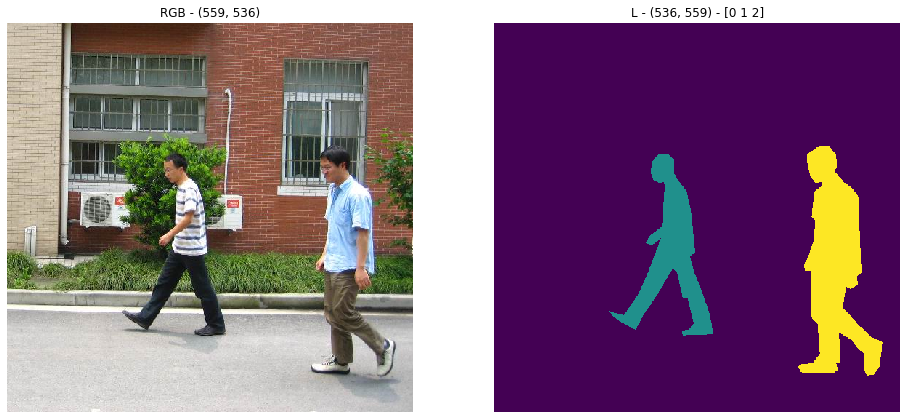

In [5]:
# view the first image
img = Image.open(img_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
img_label = f'{img.mode} - {img.size}'
mask_label = f'{mask.mode} - {mask_np.shape} - {np.unique(mask_np)}'

show_ims(
    im_paths=[img_path, mask_path],
    labels=[img_label, mask_label],
    size=8
)

In [6]:
# read the annotation of the first image
print(Path(annotation_path).read_text())

# Compatible with PASCAL Annotation Version 1.00
Image filename : "PennFudanPed/PNGImages/FudanPed00001.png"
Image size (X x Y x C) : 559 x 536 x 3
Database : "The Penn-Fudan-Pedestrian Database"
Objects with ground truth : 2 { "PASpersonWalking" "PASpersonWalking" }
# Note there may be some objects not included in the ground truth list for they are severe-occluded
# or have very small size.
# Top left pixel co-ordinates : (1, 1)
# Details for pedestrian 1 ("PASpersonWalking")
Original label for object 1 "PASpersonWalking" : "PennFudanPed"
Bounding box for object 1 "PASpersonWalking" (Xmin, Ymin) - (Xmax, Ymax) : (160, 182) - (302, 431)
Pixel mask for object 1 "PASpersonWalking" : "PennFudanPed/PedMasks/FudanPed00001_mask.png"

# Details for pedestrian 2 ("PASpersonWalking")
Original label for object 2 "PASpersonWalking" : "PennFudanPed"
Bounding box for object 2 "PASpersonWalking" (Xmin, Ymin) - (Xmax, Ymax) : (420, 171) - (535, 486)
Pixel mask for object 2 "PASpersonWalking" : "PennF

Bounding boxes around objects can be obtained from masks as well:

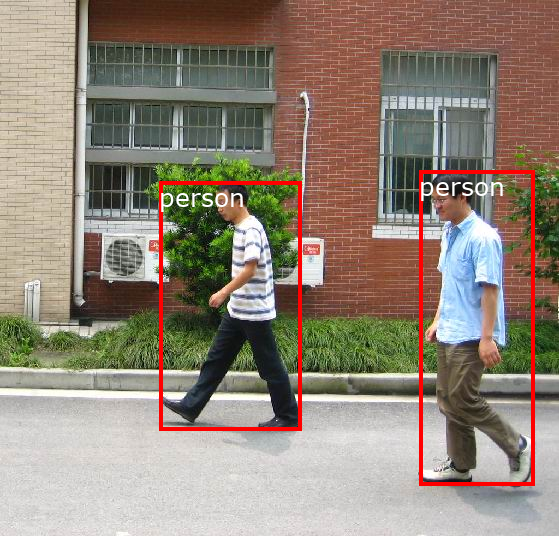

In [7]:
# plot bounding boxes around objects
label_idx = 1
label_name = 'person'
bboxes = AnnotationBbox.from_mask(
    mask_path,
    label_idx=label_idx,
    label_name=label_name
)
plot_boxes(Image.open(img_path), bboxes)

Putting together the image, the mask and boudning boxes, we get:

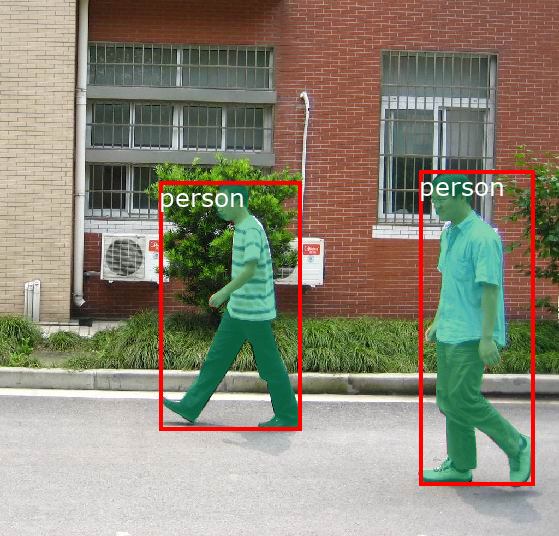

In [8]:
# visualise mask and bounding box
maksed_img = plot_mask(img_path, mask_path)
plot_boxes(maksed_img, bboxes)

## Instance Segmentation with Pretrained Mask R-CNN Model

We will use the pretrained [Mask R-CNN ResNet-50 FPN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) in PyTorch for instance segmentation.  As said in [the doc](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn), the model is pretrained on [COCO train2017](http://images.cocodataset.org/zips/train2017.zip) (18GB).  It expects a list of images as `List[Tensor[C, H, W]]` in the range of `0-1` and returns the predictions as `List[Dict[Tensor]]`.  The fields of the `Dict` include `scores`, `labels`, `boxes` and `masks`, each of which is of the same length as the input image list.  The `labels` belong to the 91 categories in the [COCO datasets](http://cocodataset.org/) within which 'person' is one category.

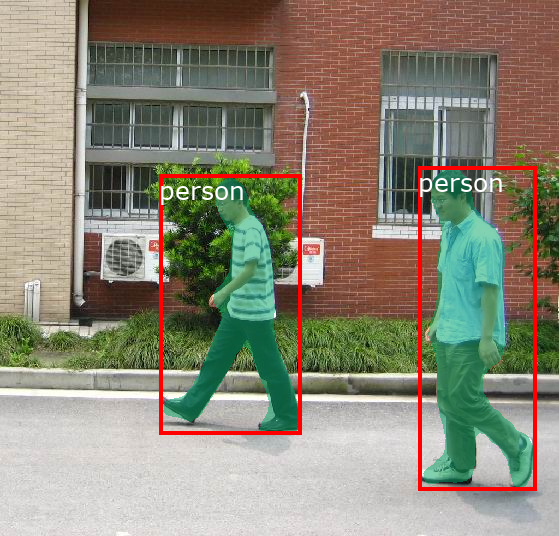

In [9]:
# get pretrained model
detector = MaskLearner(device=device)
# predict
bboxes, binary_masks = detector.predict(img_path, threshold=0.5, mask_threshold=0.5)
# plot
maksed_img = plot_mask(img_path, binary_masks)
plot_boxes(maksed_img, bboxes)

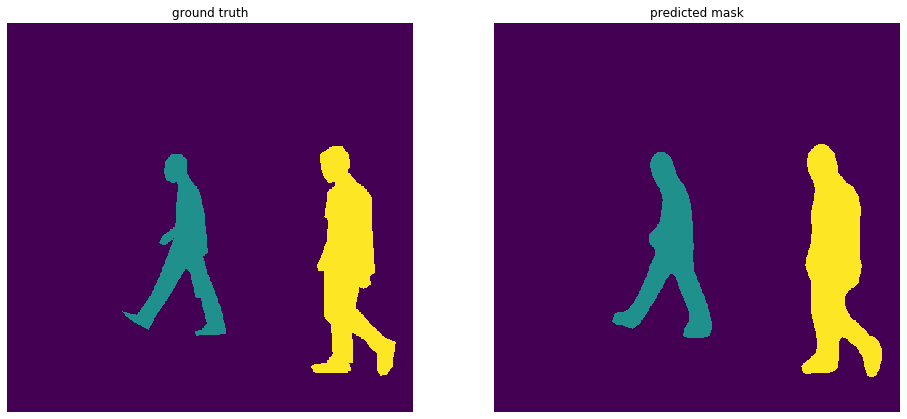

In [10]:
# compare ground truth and predicted mask
show_ims(
    im_paths=[mask_path, merge_binary_masks(binary_masks)],
    labels=['ground truth', 'predicted mask'],
    size=8
)

## Define Dataset

In [11]:
mask_data = PennFudanDataset()
mask_data[0]

(tensor([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
          [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
          [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
          ...,
          [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
          [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
          [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
          [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
          [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
          ...,
          [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
          [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
          [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
          [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
          [0.6863, 0.6471, 0.6235,  ...,

## Finetuning Mask R-CNN model

### Train

In [16]:
# train
torch.manual_seed(1)
detector = MaskLearner(mask_data, device=device)
detector.fit(epochs=3, lr=0.005, print_freq=10)

Epoch: [0]  [0/3]  eta: 0:00:38  lr: 0.002502  loss: 2.6992 (2.6992)  loss_classifier: 0.4458 (0.4458)  loss_box_reg: 0.1751 (0.1751)  loss_mask: 2.0721 (2.0721)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 12.9067  data: 0.6656  max mem: 0
Epoch: [0]  [2/3]  eta: 0:00:10  lr: 0.005000  loss: 2.6992 (2.7704)  loss_classifier: 0.4458 (0.4330)  loss_box_reg: 0.1815 (0.2368)  loss_mask: 2.0721 (2.0573)  loss_objectness: 0.0459 (0.0345)  loss_rpn_box_reg: 0.0091 (0.0088)  time: 10.4852  data: 0.2235  max mem: 0
Epoch: [0] Total time: 0:00:31 (10.5913 s / it)
creating index...
index created!
Test:  [0/3]  eta: 0:00:36  model_time: 11.3397 (11.3397)  evaluator_time: 0.1053 (0.1053)  time: 12.1272  data: 0.6820  max mem: 0
Test:  [2/3]  eta: 0:00:10  model_time: 10.1653 (10.2980)  evaluator_time: 0.0838 (0.0897)  time: 10.6168  data: 0.2276  max mem: 0
Test: Total time: 0:00:32 (10.6963 s / it)
Averaged stats: model_time: 10.1653 (10.2980)  evaluator_time: 0.083

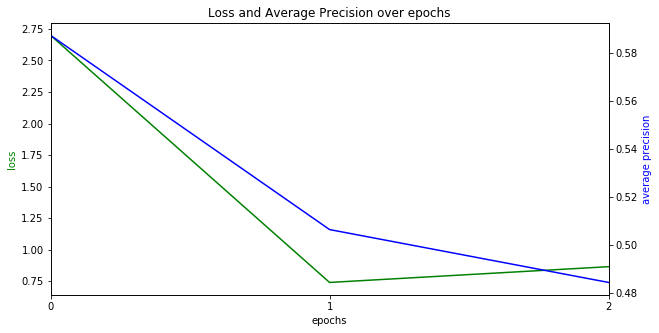

In [13]:
detector.plot_precision_loss_curves()

### Evaluate

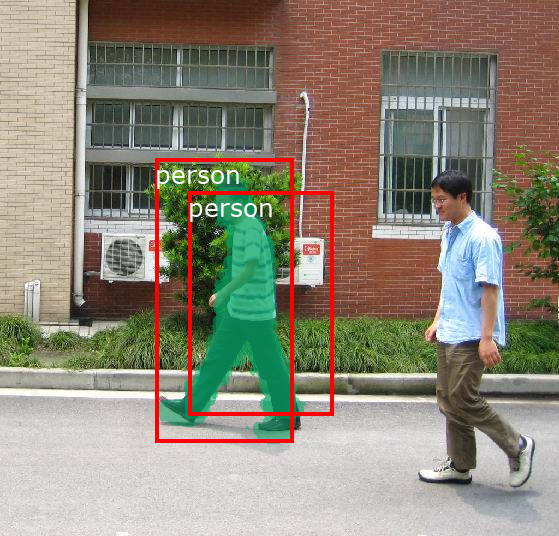

In [21]:
# predict
bboxes, binary_masks = detector.predict(img_path, threshold=0.05, mask_threshold=0.1)
# plot
maksed_img = plot_mask(img_path, binary_masks[1:3])
plot_boxes(maksed_img, bboxes[1:3])

## Keypoint R-CNN

In [ ]:
# wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip; unzip annotations_trainval2017.zip

### Prediction

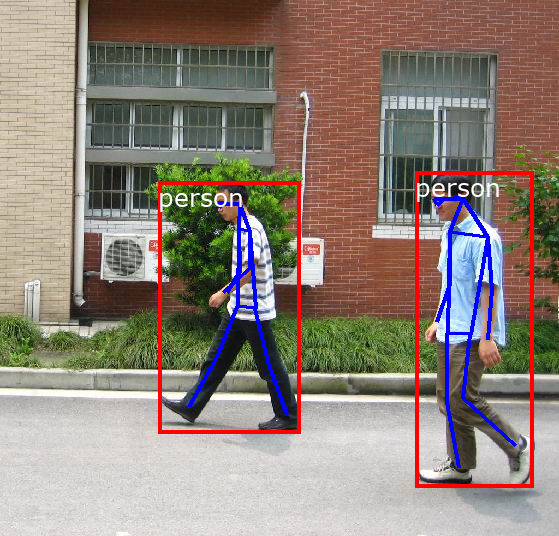

In [15]:
# predict
detector = KeypointLearner(device=device)
bboxes, keypoints = detector.predict(img_path, threshold=0.5)
# plot
keypoint_img = plot_keypoints(img_path, keypoints)
plot_boxes(keypoint_img, bboxes)

## Conclusion